In [9]:
# NetKet
import netket as nk

# json for saving and reading log files
import json

# Jax and Flax
import jax
import jax.numpy as jnp
import flax.linen as nn

# Numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt


from scipy.sparse.linalg import eigsh


The Lindblad master equation that is encoded in the Liouvillian is:

$$
\mathcal{L} = -i \left[ \hat{H}, \hat{\rho}\right] + \sum_i \left[ \hat{L}_i\hat{\rho}\hat{L}_i^\dagger -
    \left\{ \hat{L}_i^\dagger\hat{L}_i, \hat{\rho} \right\} \right]
$$

$L_i$ are jump operators

We will be studying 1D transverse field Ising model
$$
H = -h \sum_i \sigma_i^x - J \sum_{⟨i,j⟩} \sigma_i^z \sigma_j^z
$$
with $L_i = \sigma_i^-$ jump operators.

For theory see papers:
This ansatz, original paper and applied to quantum tomography:
- G. Torlai and R. G. Melko, Phys. Rev. Lett. 120, 240503 (2018).
Applied to VMC:
- F. Vicentini, A. Biella, N. Regnault, and C. Ciuti, Phys. Rev. Lett. 122, 250503 (2019).
- N. Yoshioka and R. Hamazaki, Phys. Rev. B 99, 214306 (2019).
- A. Nagy and V. Savona, Phys. Rev. Lett. 122, 250501 (2019).
- M. J. Hartmann and G. Carleo, Phys. Rev. Lett. 122, 250502 (2019).

Better ansatz:
- F. Vicentini, R. Rossi, and G. Carleo, (2022).


In [18]:
N = 6
g = nk.graph.Chain(length=N, pbc=True)
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

h = 1/8

ham = nk.operator.Ising(hi, graph=g, h=h, J=-1/4)
jump_ops = [nk.operator.spin.sigmam(hi, i) for i in range(N)]
lind = nk.operator.LocalLiouvillian(ham, jump_ops)


## Exact diagonalization

Operator $\hat{L}$ is in vectorized space.
The row-stacked, matrix-representation of the Liouvillian is then given by the following formula:
$$
\hat{\mathcal{L}} = -i \hat{H}_{nh} \otimes \hat{I} + i \hat{I} \otimes \hat{H}_{nh}^\star + \sum_i  \hat{L}_i\otimes\hat{L}_i^\star
$$
where
$$
\hat{H}_{nh} = \hat{H} - \sum_i \frac{i}{2}\hat{L}_i^\dagger\hat{L}_i
$$

$\hat{L}$ is now a matrix of size $2^{2N} \times 2^{2N}$, whereas $\rho$ is a vector but such vector that its matrix representation follows the property of density matrices (e.g. be careful with normalization!).

In [19]:
# Extract ρ in steady state
Lmat = lind.to_sparse()
print(Lmat.shape)


(4096, 4096)


How should we do exact diagonalization?

In [41]:
eigval, eigvecs = eigsh(Lmat, k=2, which="SM")
# Lowest eigenvalue in magnitude should be close to zero
assert np.abs(eigval[0]) < 1e-10
# The next eigenvalue should be considerably larger
assert np.abs(eigval[0]/eigval[1]) < 1e-10

# Determine the phase and normalize ρ
rho0 = eigvecs[:, 0].reshape(2**N, 2**N)
angles = np.angle(rho0.diagonal())
assert (np.max(np.abs(angles-angles[2])) < 1e-6)  # global phase
angle = angles[2]
rho0 *= np.exp(-angle*1j)
rho0.diagonal()
rho0 /= rho0.trace()
# In the steady-state dρ/dt = L.ρ 0
assert np.max(np.abs(Lmat@rho0.reshape(2**(2*N), 1))) < 1e-10

# L·ρ should be small
np.max(np.abs(Lmat@np.reshape(rho0, np.prod(rho0.shape))))


1.6778841890904673e-14

In [32]:
eigval, eigvecs = eigsh(Lmat.conj().T@Lmat, k=2, which="SA")
# Lowest eigenvalue in magnitude should be close to zero
assert np.abs(eigval[0]) < 1e-10
# The next eigenvalue should be considerably larger
assert np.abs(eigval[0]/eigval[1]) < 1e-10

# Determine the phase and normalize ρ
rho_LdagL = eigvecs[:, 0].reshape(2**N, 2**N)
angles = np.angle(rho_LdagL.diagonal())
assert (np.max(np.abs(angles-angles[2])) < 1e-6)  # global phase
angle = angles[2]
rho_LdagL *= np.exp(-angle*1j)
rho_LdagL.diagonal()
rho_LdagL /= rho_LdagL.trace()
# In the steady-state dρ/dt = L.ρ 0
assert np.max(np.abs(Lmat@rho_LdagL.reshape(2**(2*N), 1))) < 1e-10

# L·ρ should be small
np.max(np.abs(Lmat@np.reshape(rho_LdagL, np.prod(rho_LdagL.shape))))


1.021407087982089e-15

What is the purity?

In [42]:
np.trace(rho0@rho0)


(0.9960534908725468+1.6059120865301493e-15j)

#### NetKet's optimization

As we have seen, NetKet vectorizes $\mathcal{L}$.
It stores two Hilbert spaces.

In [43]:
print(lind.hilbert)
print(lind.hilbert_physical)


DoubledHilbert(Spin(s=1/2, N=6))
Spin(s=1/2, N=6)


When we are doing MC, we treat $\rho$ as a vector with variable $[\sigma; \sigma']$.
Thus we define Markov chain walk in the doubled Hilbert space.

In [44]:
sampler = nk.sampler.MetropolisLocal(lind.hilbert)
# Stochastic gradient descen
optimizer = nk.optimizer.Sgd(0.05)
# Stochastic reconfiguration - quantum geometric tensor
sr = nk.optimizer.SR(diag_shift=0.01)


In [45]:
# So far the only model in NetKet
model = nk.models.NDM(alpha=1, beta=4/N)

vqs = nk.vqs.MCMixedState(sampler, model, n_samples=512, n_samples_diag=1024)
vqs.init_parameters(jax.nn.initializers.normal(stddev=0.01))
ss = nk.SteadyState(lind, optimizer, variational_state=vqs, preconditioner=sr)


In [46]:
ss.run(n_iter=500)


No output specified (out=[apath|nk.logging.JsonLogger(...)]).Running the optimization but not saving the output.


100%|██████████| 500/500 [00:21<00:00, 22.88it/s, LdagL=0.000053 ± 0.000011 [σ²=0.000000, R̂=1.0251]]   


()

Model's rank: 16 vs true 63
Purity: (0.9801354556693965+0j) vs (0.9960534908725468+1.6059120865301493e-15j)


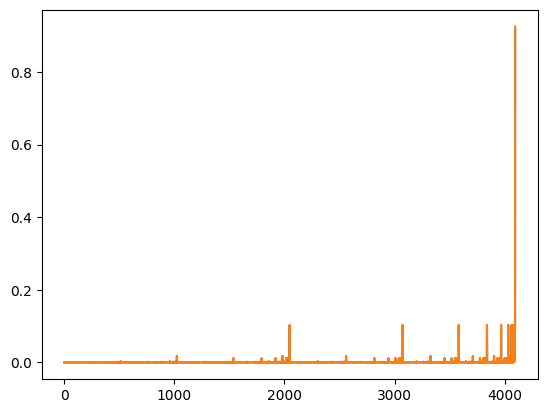

In [50]:
vqs_rho = vqs.to_matrix()
plt.plot(np.abs(vqs_rho.reshape(-1)))
plt.plot(np.abs(rho0.reshape(-1)))
# plt.plot(np.abs(vqs_rho.reshape(-1) - rho0.reshape(-1)))
print("Model's rank:", np.linalg.matrix_rank(vqs_rho) ,"vs true", np.linalg.matrix_rank(rho0))
print("Purity:", np.trace(vqs_rho@vqs_rho), "vs", np.trace(rho0@rho0))


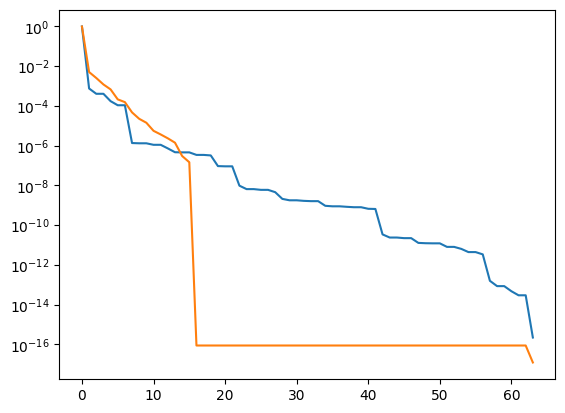

In [55]:
u,s,v = np.linalg.svd(rho0)
plt.semilogy(s)
u,s,v = np.linalg.svd(vqs_rho)
plt.semilogy(s)


## More mixed state

Redo the equations with $h=1/3$.
How does parameter $\alpha$ and $\beta$ affect the precision?

4.670499334398404e-16
(0.800942100971405-3.271037954388767e-16j)


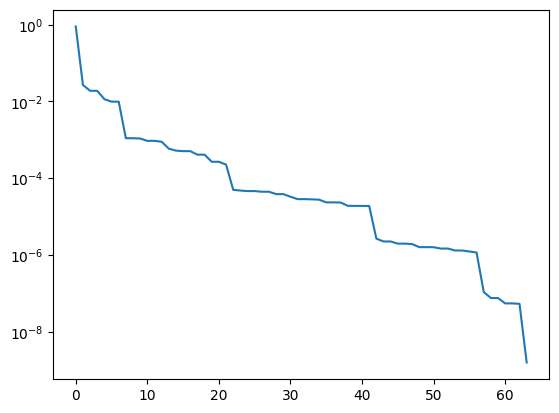

In [57]:
N = 6
g = nk.graph.Chain(length=N, pbc=True)
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

h = 1/3

ham = nk.operator.Ising(hi, graph=g, h=h, J=-1/4)
jump_ops = [nk.operator.spin.sigmam(hi, i) for i in range(N)]
lind = nk.operator.LocalLiouvillian(ham, jump_ops)
Lmat = lind.to_sparse()

eigval, eigvecs = eigsh(Lmat, k=2, which="SM")
# Lowest eigenvalue in magnitude should be close to zero
assert np.abs(eigval[0]) < 1e-10
# The next eigenvalue should be considerably larger
assert np.abs(eigval[0]/eigval[1]) < 1e-10

# Determine the phase and normalize ρ
rho0 = eigvecs[:, 0].reshape(2**N, 2**N)
angles = np.angle(rho0.diagonal())
assert (np.max(np.abs(angles-angles[0])) < 1e-10)  # global phase
angle = angles[0]
rho0 *= np.exp(-angle*1j)
rho0.diagonal()
rho0 /= rho0.trace()
# In the steady-state dρ/dt = L.ρ 0
assert np.max(np.abs(Lmat@rho0.reshape(2**(2*N), 1))) < 1e-10

# L·ρ should be small
print(np.max(np.abs(Lmat@np.reshape(rho0, np.prod(rho0.shape)))))

# Purity
print(np.trace(rho0@rho0))

# Rank
u, s, v = np.linalg.svd(rho0)
plt.semilogy(s)


In [58]:
sampler = nk.sampler.MetropolisLocal(lind.hilbert)
# Stochastic gradient descen
optimizer = nk.optimizer.Sgd(0.05)
# Stochastic reconfiguration - quantum geometric tensor
sr = nk.optimizer.SR(diag_shift=0.01)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:45<00:00, 22.18it/s, LdagL=0.00230 ± 0.00030 [σ²=0.00002, R̂=1.0314]]


Model's rank: 4 vs true 64
Purity: (0.8814363109649084+0j) vs (0.800942100971405-3.271037954388767e-16j)


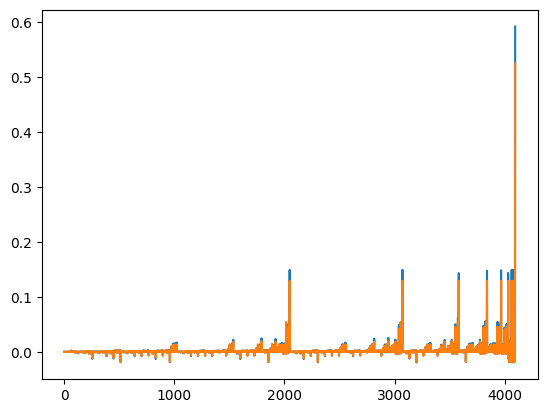

100%|██████████| 1000/1000 [00:49<00:00, 20.03it/s, LdagL=0.00076 ± 0.00026 [σ²=0.00002, R̂=1.0255]]  


Model's rank: 64 vs true 64
Purity: (0.8396806459472623+0j) vs (0.800942100971405-3.271037954388767e-16j)


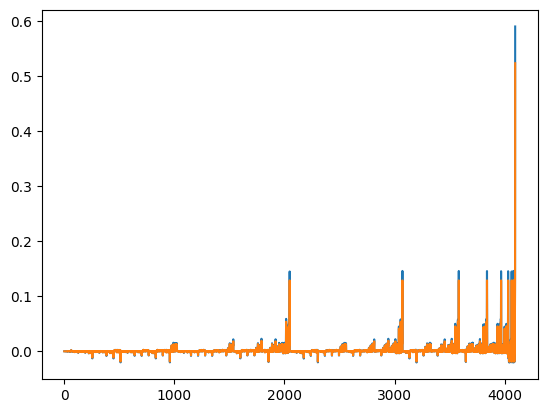

100%|██████████| 1000/1000 [01:01<00:00, 16.20it/s, LdagL=0.00079 ± 0.00043 [σ²=0.00005, R̂=1.0446]]  


Model's rank: 64 vs true 64
Purity: (0.8340497759115468+0j) vs (0.800942100971405-3.271037954388767e-16j)


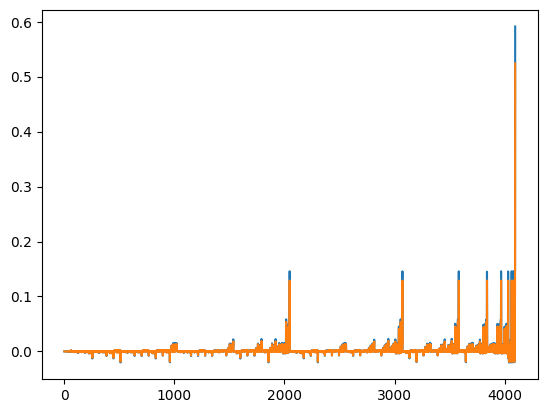

In [61]:
for beta in [2,6,10]:

  model = nk.models.NDM(alpha=4, beta=beta/N)

  vqs = nk.vqs.MCMixedState(sampler, model, n_samples=256, n_samples_diag=256)
  vqs.init_parameters(jax.nn.initializers.normal(stddev=0.01))
  ss = nk.SteadyState(lind, optimizer, variational_state=vqs, preconditioner=sr)
  ss.run(n_iter=1000, out=f"LdagL_beta_{beta}")

  vqs_rho = vqs.to_matrix()
  print("Model's rank:", np.linalg.matrix_rank(vqs_rho) ,"vs true", np.linalg.matrix_rank(rho0))
  print("Purity:", np.trace(vqs_rho@vqs_rho), "vs", np.trace(rho0@rho0))
  plt.plot(vqs.to_array())
  plt.plot(rho0.reshape(-1))
  plt.show()


100%|██████████| 1000/1000 [01:06<00:00, 15.07it/s, LdagL=0.000505 ± 0.000098 [σ²=0.000002, R̂=1.0807]]


Model's rank: 64 vs true 64
Purity: (0.8356815201903518+0j) vs (0.800942100971405-3.271037954388767e-16j)


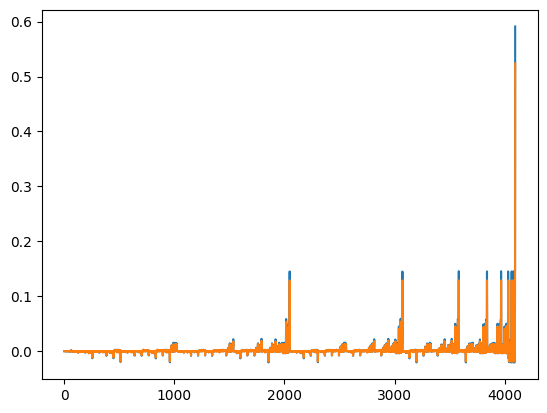

In [62]:
for beta in [15]:

  model = nk.models.NDM(alpha=4, beta=beta/N)

  vqs = nk.vqs.MCMixedState(sampler, model, n_samples=256, n_samples_diag=256)
  vqs.init_parameters(jax.nn.initializers.normal(stddev=0.01))
  ss = nk.SteadyState(lind, optimizer, variational_state=vqs, preconditioner=sr)
  ss.run(n_iter=1000, out=f"LdagL_beta_{beta}")

  vqs_rho = vqs.to_matrix()
  print("Model's rank:", np.linalg.matrix_rank(vqs_rho) ,"vs true", np.linalg.matrix_rank(rho0))
  print("Purity:", np.trace(vqs_rho@vqs_rho), "vs", np.trace(rho0@rho0))
  plt.plot(vqs.to_array())
  plt.plot(rho0.reshape(-1))
  plt.show()
